# Word Embeddings

- The state-of-art way of vectorizing texts is to learn the numeric representations of words based on deep learning methods.
- These deep-learning based numeric representations of linguistic units are commonly referred to as **embeddings**.


## Overview

### What is **Word Embeddings**?

- `Word2vec` is one of the most popular techniques to learn word embeddings using a two-layer neural network.
- The input is a text corpus and the output is a set of word vectors.
- Different from the bag-of-words method, these embeddings are learned by training the model to optimize general language modeling tasks.
- Reseach has shown that these embeddings include more semantic information of words, which allow us to perform interesting semantic computation.

### Main training algorithms

- Continuous bag-of-words (**CBOW**): The general language modeling task for embeddings training is to learn a model that is capable of using the context words to predict a target word.
- **Skip-gram**: The general language modeling task for embeddings training is to learn a model that is capable of using a word to predict its target context words.
- Other variants of embeddings training:
  - `fasttext` from Facebook
  - `GloVe` from Stanford NLP Group (?)
- There are many ways to train work embeddings.
  - `gensim`
  - Training based on deep learning packages (e.g., `keras`, `tensorflow`)
  - `spacy` (It comes with many pre-trained embeddings models.)


## An Intuitive Understanding of CBOW

![](../images/word2vec-text-to-sequences.gif)

![](../images/word2vec-cbow.gif)

## An Intuitive Understanding of Skip-gram

![](../images/word2vec-skipgram.gif)

## Import necessary dependencies and settings

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 200
%matplotlib inline

In [3]:
# Google Colab Adhoc Setting
!nvidia-smi
nltk.download(['gutenberg','punkt','stopwords'])
!pip show spacy
!pip install --upgrade spacy
#!python -m spacy download en_core_web_trf
!python -m spacy download en_core_web_lg

Mon Mar  1 00:20:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Sample corpus of text documents

In [4]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals


## Simple text pre-processing

In [5]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [6]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

## Load up sample corpus - Bible

In [7]:
from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


## Leveraging `genism` for building a `word2vec` skip-gram model


In [8]:
%%time
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50, sg = 1) # `sg=1` for skip-gram; `sg=0` for CBOW

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words

CPU times: user 4min 29s, sys: 476 ms, total: 4min 29s
Wall time: 2min 18s


### Visualizing word embeddings

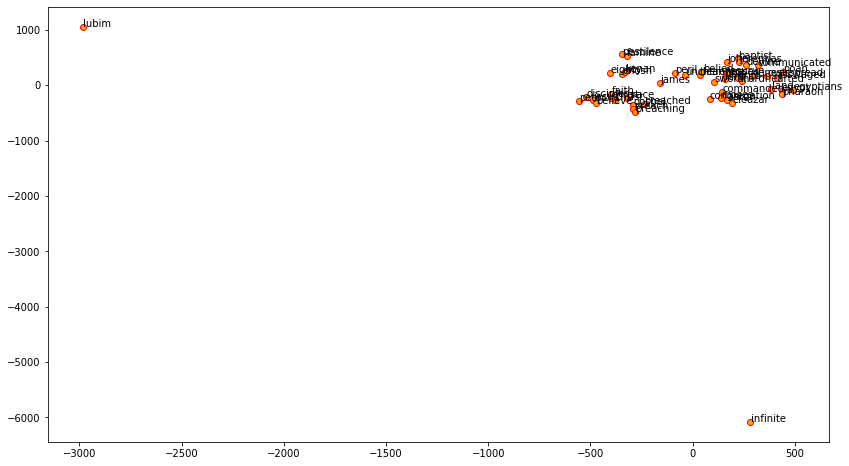

In [9]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

### Applying the word2vec model on our sample corpus

In [10]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

### Visualize word embeddings

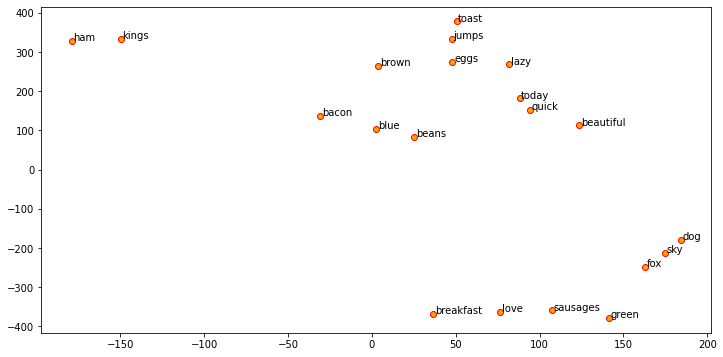

In [11]:
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

### Sample word embedding

In [12]:
w2v_model.wv['sky']

array([-0.04863533,  0.01926509,  0.03851043,  0.04266324,  0.02200821,
        0.0139389 , -0.00343255,  0.01205156,  0.04465897,  0.04750963],
      dtype=float32)

### Build framework for getting document level embeddings

In [13]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [14]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7,8,9
0,-0.020722,-0.012895,0.000867,0.038041,-0.011488,-0.007021,-0.018208,0.011283,0.021614,0.046976
1,-0.008103,-0.005894,0.002931,0.038980,0.002077,-0.015994,-0.003397,0.000140,0.019617,0.039639
2,0.011011,-0.027501,-0.014630,0.007998,-0.013818,0.002774,0.008962,-0.002900,0.026240,0.002660
3,-0.007562,-0.005414,0.003374,0.017749,-0.005837,-0.014872,-0.007558,-0.006800,-0.008314,0.002462
4,0.017229,-0.018270,0.008158,0.013537,0.007110,-0.020442,0.007767,-0.017325,0.003271,0.003144
5,0.015855,-0.024324,-0.008383,0.020297,-0.019622,0.008106,0.000906,-0.005909,0.021341,0.006865
6,-0.024971,-0.003779,-0.000594,0.029257,-0.011523,-0.000702,-0.014243,0.004398,0.027949,0.035934
7,0.017188,-0.022781,-0.010718,0.019301,-0.018644,0.008432,0.010752,-0.004320,0.024858,-0.000484


### Clustering with word embeddings

In [15]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,0
1,Love this blue and beautiful sky!,weather,0
2,The quick brown fox jumps over the lazy dog.,animals,2
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,1
4,"I love green eggs, ham, sausages and bacon!",food,1
5,The brown fox is quick and the blue dog is lazy!,animals,2
6,The sky is very blue and the sky is very beautiful today,weather,0
7,The dog is lazy but the brown fox is quick!,animals,2


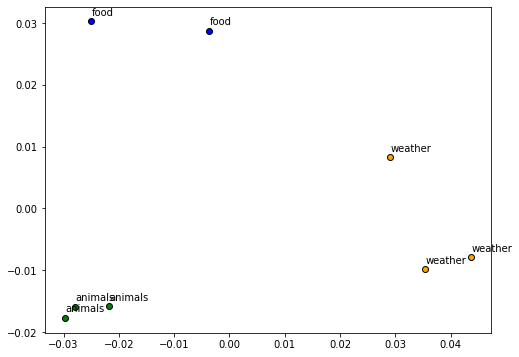

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(corpus_df['Category'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')

## Leveraging `spacy` for Pre-trained GloVe Embeddings

In [24]:
import spacy

nlp = spacy.load('en_core_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 684830


### Visualize GloVe word embeddings

In [25]:
unique_words = list(set([word for sublist in [doc.split() for doc in norm_corpus] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
lazy,-0.353320,-0.299710,-0.176230,-0.321940,-0.385640,0.586110,0.411160,-0.418680,0.073093,1.48650,0.178510,-0.364790,-0.318890,-0.186660,-0.176970,-0.185470,-0.287790,0.57963,0.413430,-0.142170,-0.122250,0.093341,-0.117550,-0.436210,0.416610,-0.172810,0.080734,-0.534250,0.790970,-0.175410,-0.503800,0.092905,0.000162,-0.636440,0.064689,0.262830,0.266300,0.183250,-0.397460,0.109490,...,-0.185390,0.121400,-0.077576,-0.188900,0.394630,-0.383130,-0.288160,-0.359380,0.64202,0.084683,-0.288520,-0.443680,-0.141780,-0.207710,0.006349,-0.368950,-0.082058,-0.195290,-0.067179,0.001303,0.468360,-0.175710,0.198760,0.467780,0.593930,-0.335560,-0.072169,-0.369840,0.114630,0.430670,0.402310,-0.038554,-0.288670,-0.244130,0.460990,0.514170,0.136260,0.344190,-0.845300,-0.077383
love,0.139490,0.534530,-0.252470,-0.125650,0.048748,0.152440,0.199060,-0.065970,0.128830,2.05590,-0.443390,-0.101740,0.271180,-0.124290,-0.457530,0.055878,-0.303950,0.79543,-0.290600,0.519080,0.169090,-0.327430,0.206060,-0.083885,0.196960,0.328470,0.087838,-0.127840,0.309790,0.206920,-0.085855,0.547900,-0.423440,0.345730,0.229210,-0.215380,0.091481,-0.278010,-0.341830,-0.130670,...,0.055732,0.319250,-0.262930,0.306830,0.094407,0.344400,0.303240,0.417650,-0.10427,0.418500,-0.678930,-0.160720,-0.820230,-0.014762,-0.091018,-0.008955,-0.026122,-0.134550,0.192630,0.331130,-0.152970,-0.368220,-0.146490,-0.315470,0.139630,0.298850,0.671980,0.220490,-0.182790,-0.248110,-0.124380,0.178440,-0.099469,0.008682,0.089213,-0.075513,-0.049069,-0.015228,0.088408,0.302170
quick,-0.445630,0.191510,-0.249210,0.465900,0.161950,0.212780,-0.046480,0.021170,0.417660,1.68690,-0.451860,-0.011807,0.072409,-0.114820,-0.534210,-0.150700,-0.352960,1.71150,-0.211920,-0.400470,-0.420410,0.076042,0.023444,-0.744810,0.006499,0.443510,0.484180,-0.541020,0.375070,-0.595550,0.097029,0.119870,-0.079122,-0.053397,-0.028888,0.157510,0.164100,0.288250,-0.065758,-0.240000,...,-0.185420,-0.064913,0.242120,-0.674920,0.394260,-0.304280,0.103000,0.336920,0.30043,0.349690,0.353660,0.017008,-0.170840,-0.286230,-0.106920,0.313400,0.307010,-0.103920,0.231590,0.027126,0.169710,0.010259,-0.171380,0.448950,-0.293820,-0.312280,-0.054189,0.069783,-0.104720,-0.124150,-0.329460,0.421860,-0.039543,0.150180,0.338220,0.049554,0.149420,-0.038789,-0.019069,0.348650
brown,-0.374120,-0.076264,0.109260,0.186620,0.029943,0.182700,-0.631980,0.133060,-0.128980,0.60343,-0.680410,-0.142220,-0.133570,-0.659430,0.052402,0.167450,0.639230,1.76800,0.346190,-0.624800,-0.128670,-0.197030,-0.374500,0.330640,0.046832,-0.653510,-0.561360,0.227370,0.229230,-0.415810,-0.167670,0.335430,0.097227,-0.467030,-0.026857,-0.067665,-0.192110,-0.133740,0.016268,-0.208270,...,0.117450,0.055016,0.236820,0.898190,-0.409690,0.075218,-0.110300,-0.409910,-0.95718,0.527490,-0.042655,0.266180,0.305260,-0.519010,-0.460440,-0.093834,0.130060,0.019268,0.010198,0.007583,0.295510,0.231560,-0.034880,-0.116940,-0.327330,0.204910,0.475000,0.513100,-0.145760,-0.185080,-0.015404,0.392890,-0.034826,-0.720300,-0.365320,0.740510,0.108390,-0.365760,-0.288190,0.114630
today,-0.156570,0.594890,-0.031445,-0.077586,0.278630,-0.509210,-0.066350,-0.081890,-0.047986,2.80360,-0.131820,-0.627100,0.253880,-0.472910,-0.428750,0.143520,-0.118180,0.67974,-0.006229,-0.001527,-0.163790,-0.034067,0.271020,0.054245,-0.011752,0.324470,-0.321400,-0.003704,-0.205390,0.057008,0.177460,-0.166030,0.505320,-0.215200,0.010503,0.598390,0.021347,0.103650,0.023387,0.097183,...,0.553160,0.100970,-0.386630,0.012178,-0.181380,-0.381290,-0.200480,-0.347470,0.70278,0.299910,-0.198150,0.041330,-0.169990,0.346500,-0.135520,0.162350,-0.145150,0.289770,0.095377,-0.113840,0.372630,-0.116170,0.091593,0.126660,-0.035243,0.261140,0.235310,-0.323920,-0

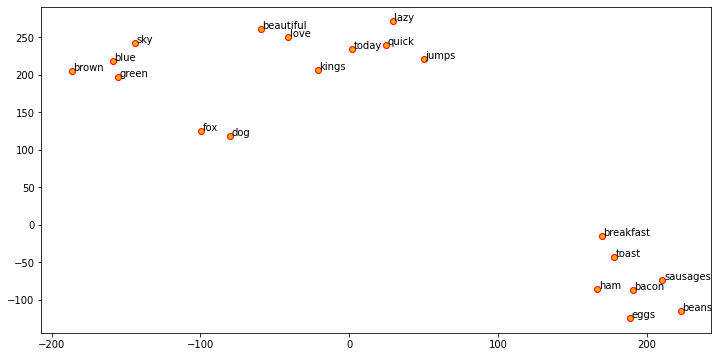

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

### Cluster documents with GloVe Embeddings

In [28]:
doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in norm_corpus])

import sklearn
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,1
1,Love this blue and beautiful sky!,weather,1
2,The quick brown fox jumps over the lazy dog.,animals,2
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,0
4,"I love green eggs, ham, sausages and bacon!",food,0
5,The brown fox is quick and the blue dog is lazy!,animals,2
6,The sky is very blue and the sky is very beautiful today,weather,1
7,The dog is lazy but the brown fox is quick!,animals,2


## Leveraging `gensim` for building a FastText model

In [29]:
%%time
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)


In [30]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words

{'egypt': ['land', 'pharaoh', 'egyptians', 'israel', 'pathros'],
 'famine': ['pestilence', 'sword', 'blasted', 'shephatiah', 'mildew'],
 'god': ['lord', 'therefore', 'unto', 'christ', 'also'],
 'gospel': ['preach', 'preached', 'christ', 'preaching', 'grace'],
 'jesus': ['christ', 'god', 'faith', 'disciples', 'grace'],
 'john': ['baptist', 'peter', 'baptize', 'baptized', 'philip'],
 'moses': ['aaron', 'commanded', 'congregation', 'spake', 'israel'],
 'noah': ['shem', 'methuselah', 'flood', 'japheth', 'creepeth']}

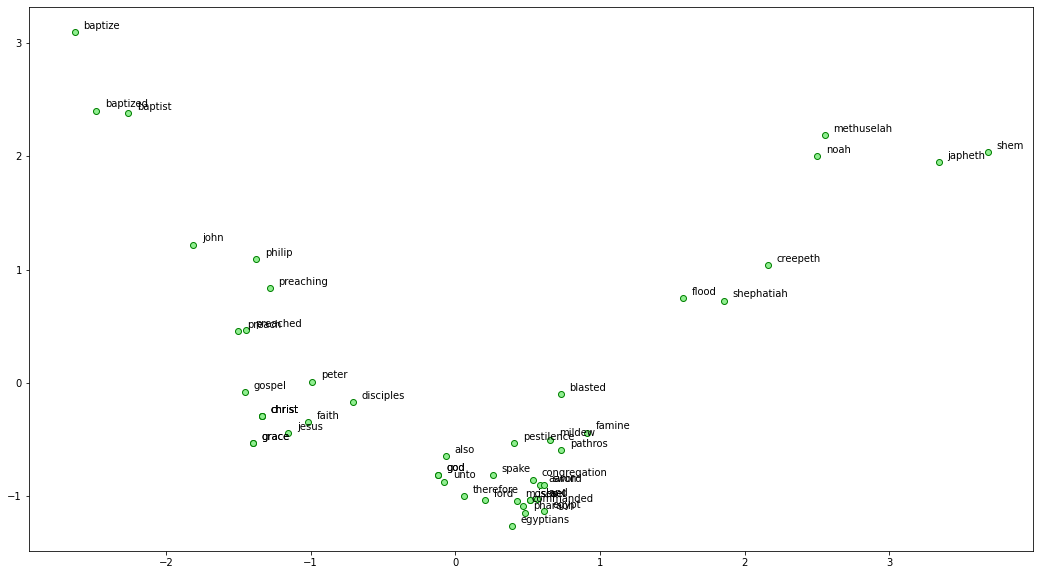

In [31]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [32]:
ft_model.wv['jesus']

array([-0.31373277,  0.24986652, -0.00367668,  0.21423288,  0.04567473,
       -0.04502545, -0.07046528, -0.5637045 , -0.42696762,  0.29426795,
        0.18720292, -0.6424968 ,  0.10201346, -0.24982215,  0.02858064,
        0.3755699 ,  0.28008053,  0.012965  ,  0.33426148, -0.07878435,
       -0.01983238,  0.17766935,  0.02893843,  0.32203683,  0.28054443,
       -0.09005316,  0.0987089 , -0.22138645, -0.31606898,  0.22938365,
       -0.01445512, -0.17707585,  0.20032842,  0.15179242, -0.16822553,
       -0.13566902,  0.0005343 ,  0.0721856 , -0.69524443,  0.43080416,
       -0.21818122,  0.23006764, -0.33329317,  0.07751293,  0.27338496,
       -0.35498056,  0.1503952 ,  0.28976926,  0.02623105,  0.03571241,
        0.00480933,  0.1433095 , -0.05732399, -0.09378115, -0.07803533,
        0.42912427,  0.11038725,  0.00930797, -0.16667941,  0.06490608,
       -0.07404152, -0.64138204,  0.3414193 , -0.3284135 ,  0.58562374,
       -0.11382494,  0.01709049, -0.11023157,  0.4026227 ,  0.17

In [33]:
print(ft_model.wv.similarity(w1='god', w2='satan'))
print(ft_model.wv.similarity(w1='god', w2='jesus'))

0.26208106
0.6369799


In [34]:
st1 = "god jesus satan john"
print('Odd one out for [',st1, ']:', ft_model.wv.doesnt_match(st1.split()))

st2 = "john peter james judas"
print('Odd one out for [',st2, ']:', ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ god jesus satan john ]: satan
Odd one out for [ john peter james judas ]: judas


/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


## References

- Sarkar (2020) Ch 4 Feature Engineering for Text Representation